<a href="https://colab.research.google.com/github/tancik/6.865-Code/blob/master/1D_fig_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!pip install neural_tangents livelossplot

Thu May 28 22:01:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [0]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from jax.experimental import optimizers

from livelossplot import PlotLosses
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import time

import numpy as onp

# ## Random seed
# rand_key = random.PRNGKey(0)


In [0]:
# Utils

fplot = lambda x : np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))

# Signal makers

def sample_random_signal(key, decay_vec):
  N = decay_vec.shape[0]
  raw = random.normal(key, [N, 2]) @ np.array([1, 1j])
  signal_f = raw * decay_vec
  signal = np.real(np.fft.ifft(signal_f))
  return signal

def sample_random_powerlaw(key, N, power):
  coords = np.float32(np.fft.ifftshift(1 + N//2 - np.abs(np.fft.fftshift(np.arange(N)) - N//2)))
  decay_vec = coords ** -power
  return sample_random_signal(key, decay_vec) # * 100


# Network 

def make_network(num_layers, num_channels, num_outputs=1):
  layers = []
  for i in range(num_layers-1):
      # layers.append(stax.Dense(num_channels, parameterization='standard'))
      layers.append(stax.Dense(num_channels, parameterization='ntk'))
      layers.append(stax.Relu(do_backprop=True))
  layers.append(stax.Dense(num_outputs))
  return stax.serial(*layers)

# Encoding 

def compute_ntk(x, avals, bvals, kernel_fn):
    x1_enc = input_encoder(x, avals, bvals)
    x2_enc = input_encoder(np.array([0.], dtype=np.float32), avals, bvals)
    out = np.squeeze(kernel_fn(x1_enc, x2_enc, 'ntk'))
    return out


input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x[...,None]) * b), 
                                                a * np.cos((2.*np.pi*x[...,None]) * b)], axis=-1) / np.linalg.norm(a) #* np.sqrt(a.shape[0])



### complicated things

def predict(kernel_fn, yf_test, pred0f_test, ab, t_final, eta=None):
  N, M = yf_test.shape[-1]//2, 2
  alias_tile = lambda f : f.reshape(list(f.shape[:-1])+[M,N]).mean((-2)).tile([1]*len(f.shape[:-1])+[M])
  x_test = np.linspace(0., 1., N*M, endpoint=False)
  H_row_test = compute_ntk(x_test,  *ab, kernel_fn)
  H_t = np.real(np.fft.fft(H_row_test))
  H_d_tile = alias_tile(H_t)
  if eta is None:
    H_d_tile_train = 1. - np.exp(-t_final * H_d_tile)
  else:
    H_d_tile_train = 1. - (1. - eta * H_d_tile) ** t_final
  yf_train_tile = alias_tile(yf_test)
  pred0f_train_tile = alias_tile(pred0f_test)
  exp_term = H_d_tile_train * (yf_train_tile - pred0f_train_tile)
  pred_train = (pred0f_train_tile + exp_term)[...,:N]
  pred_test = pred0f_test + H_t / H_d_tile * exp_term
  return pred_test, pred_train

predict = jit(predict, static_argnums=(0,))

def predict_psnr(kernel_fn, yf_test, pred0f_test, ab, t_final, eta=None):
  N, M = yf_test.shape[-1]//2, 2
  alias_tile = lambda f : f.reshape(list(f.shape[:-1])+[M,N]).mean((-2)).tile([1]*len(f.shape[:-1])+[M])
  pred_test, pred_train = predict(kernel_fn, yf_test, pred0f_test, ab, t_final, eta)
  calc_psnr = lambda f, g : -10*np.mean(np.log10(np.mean(np.abs(f - g)**2, -1) / np.prod(f.shape[-1:])))
  return calc_psnr(yf_test, pred_test), calc_psnr(alias_tile(yf_test)[...,:N], pred_train)

predict_psnr = jit(predict_psnr, static_argnums=(0,))


def train_model(rand_key, network_size, lr, iters, 
                train_input, test_input, optimizer, ab, name=''):
    init_fn, apply_fn, kernel_fn = make_network(*network_size)

    run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))
    model_loss = jit(lambda params, ab, x, y: .5 * np.sum((run_model(params, ab, x) - y) ** 2))
    model_psnr = jit(lambda params, ab, x, y: -10 * np.log10(np.mean((run_model(params, ab, x) - y) ** 2)))
    model_grad_loss = jit(lambda params, ab, x, y: jax.grad(model_loss)(params, ab, x, y))

    opt_init, opt_update, get_params = optimizer(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_encoder(train_input[0], *ab).shape[-1]))
    opt_state = opt_init(params)

    pred0 = run_model(get_params(opt_state), ab, test_input[0])
    pred0_f = np.fft.fft(pred0)

    train_psnrs = []
    test_psnrs = []
    theories = []
    xs = []
    errs = []
    # groups = {'losses {}'.format(name): ['exp_train', 'exp_test', 
    #                                      'theory_train', 'theory_test', 
    #                                     #  'theory_d_train', 'theory_d_test', 
    #                                      ],}
    # plotlosses_model = PlotLosses(groups=groups)
    for i in tqdm(range(iters)):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), ab, *train_input), opt_state)

        if i % 20 == 0:
            train_psnr = model_psnr(get_params(opt_state), ab, *train_input)
            test_psnr = model_psnr(get_params(opt_state), ab, *test_input)
            theory = predict_psnr(kernel_fn, np.fft.fft(test_input[1]), pred0_f, ab, i * lr)
            # theory2 = predict_psnr(kernel_fn, np.fft.fft(test_input[1]), np.zeros_like(pred0_f), ab, i * lr)
            # plotlosses_model.update({'exp_train':train_psnr, 'exp_test':test_psnr,
            #                          'theory_test': theory[0], 'theory_train': theory[1],
            #                         #  'theory_d_test': theory2[0], 'theory_d_train': theory2[1],
            #                          }, current_step=i)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            theories.append(theory)
            pred = run_model(get_params(opt_state), ab, train_input[0])
            errs.append(pred - train_input[1])
            xs.append(i)
        # if i % 50 == 0 and i != 0:
        #     plotlosses_model.send()
    return get_params(opt_state), train_psnrs, test_psnrs, errs, np.array(theories), xs
    # return train_psnrs, test_psnrs, errs, np.array(theories), xs






# Make fig 2

In [0]:
N_train = 32
data_power = 1.0

network_size = (4, 1024)
# network_size = (8, 256)

# learning_rate = 1e-4
# learning_rate = 1e-0 / N_train
learning_rate = 5e-2
# learning_rate = 1e-2
sgd_iters = 5001

rand_key = random.PRNGKey(0)


### Draft params
# N_train = 32
# data_power = 1.0
# network_size = (4, 1024)
# learning_rate = 5e-2
# sgd_iters = 5000

In [5]:
# Signal
M = 2
N = N_train
x_test = np.float32(np.linspace(0,1.,N*M,endpoint=False))
x_train = x_test[::M]
rand_key, key = random.split(rand_key)
s = sample_random_powerlaw(key, N*M, data_power) 
s = (s-s.min()) / (s.max()-s.min()) - .5

# Kernels
bvals = np.float32(np.arange(1, N//2+1))
ab_dict = {r'$\alpha = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0, 0.5, 1, 1.5, 2]}
# ab_dict = {'power_{}'.format(p) : (bvals**-p, bvals) for p in [0.0, 1.0]}
ab_dict[r'$\alpha = \infty$'] = (np.eye(bvals.shape[0])[0], bvals)


# Train the networks

rand_key, *ensemble_key = random.split(rand_key, 1 + len(ab_dict))

outputs = {k : train_model(key, network_size, learning_rate, sgd_iters, 
                           (x_train, s[::2]), (x_test, s), 
                           optimizer=optimizers.sgd, ab=ab_dict[k], name=k) for k, key in zip(ab_dict, ensemble_key)}

## Failed attempt at vmap

# train_fn = lambda ab, key, k : train_model(key, network_size, learning_rate, sgd_iters, 
#                            (x_train, s[::2]), (x_test, s), 
#                            optimizer=optimizers.sgd, ab=ab) 

# ab_list = np.array([ab_dict[k] for k in ab_dict])
# output_list = vmap(train_fn)(np.array(ab_list), np.array(ensemble_key))
# outputs = {k : out for k, out in zip(ab_dict, output_list)}

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


#OLD

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


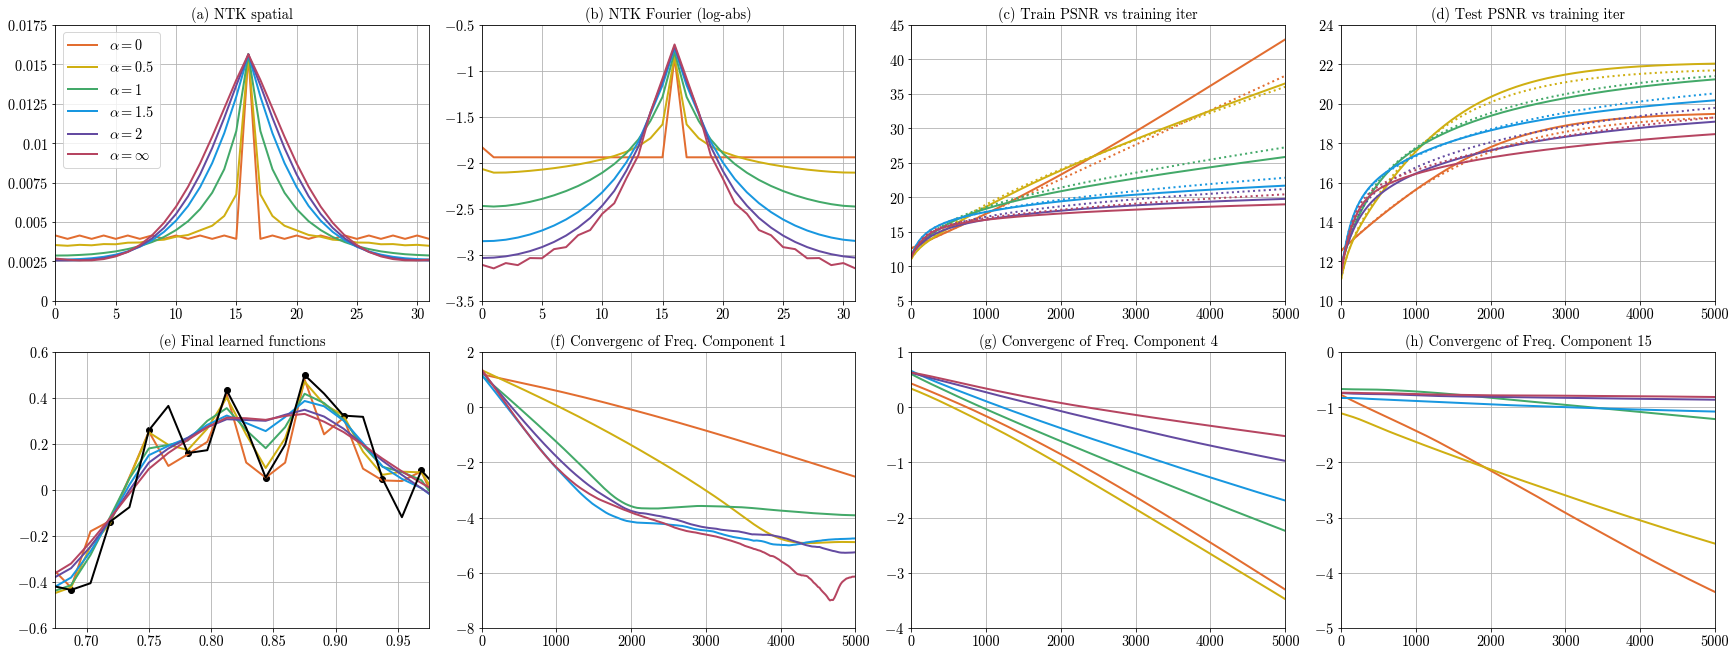

In [9]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)


names = list(outputs.keys())
names = [n for n in names if 'opt' not in n]

N_kernels = len(names)

### What's a good colormap ??
# colors_k = [plt.cm.plasma(.8 * (1. - j / (N_kernels-1))) for j in range(N_kernels)]
# colors_k = [plt.cm.terrain(.8 * (1. - j / (N_kernels-1))) for j in range(N_kernels)]
# colors_k = [np.array(plt.cm.jet(1. * (1. - j / (N_kernels-1))))[:3] * .9 for j in range(N_kernels)]
# colors_k = [np.array(plt.cm.rainbow(1. * (1. - j / (N_kernels-1))))[:3] * 1. for j in range(N_kernels)]
colors_k = np.array([[0.8872, 0.4281, 0.1875],
    [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2


xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

init_fn, apply_fn, kernel_fn = make_network(*network_size)
run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))

fig3 = plt.figure(constrained_layout=True, figsize=(24,9))
gs = fig3.add_gridspec(2, 4)

### Plot NTK stuff

H_rows = {k : compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names}

ax = fig3.add_subplot(gs[0,0])
for c, k in zip(colors_k, H_rows):
  ax.plot(np.fft.fftshift(H_rows[k]), label=k, color=c, linewidth=linewidth)
ax.set_title('(a) NTK spatial')
ax.legend(loc='upper left')
ax.set_xlim(0, 60)
plt.autoscale(enable=True, axis='x', tight=True)
# ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')

ax = fig3.add_subplot(gs[0,1])
for c, k in zip(colors_k, H_rows):
  plt.plot(fplot(H_rows[k]), label=k, color=c, linewidth=linewidth)
ax.set_title('(b) NTK Fourier (log-abs)')
# ax.legend(loc='upper right')
ax.set_xlim(0, 60)
plt.autoscale(enable=True, axis='x', tight=True)
# ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')

### Plot loss curves

train_actual = {k : outputs[k][1] for k in names}
train_theory = {k : outputs[k][4][:,1] for k in names}
test_actual = {k : outputs[k][2] for k in names}
test_theory = {k : outputs[k][4][:,0] for k in names}

xvals = xs # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[0,2])
for c, k in zip(colors_k, names):
  ax.plot(xvals, train_actual[k], color=c, label=k, linewidth=linewidth)
  ax.plot(xvals, train_theory[k], ':', color=c, linewidth=linewidth)
# ax.legend()
ax.set_title('(c) Train PSNR vs training iter')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('on')
# ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
# ax.set_yticklabels([fr'${t:g}$' for t in ax.get_yticks()])
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])


ax = fig3.add_subplot(gs[0,3])
for c, k in zip(colors_k, names):
  ax.plot(xvals, test_actual[k], color=c, label=k, linewidth=linewidth)
  ax.plot(xvals, test_theory[k], ':', color=c, linewidth=linewidth)
# ax.legend()
ax.set_title('(d) Test PSNR vs training iter')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('on')

ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])

# ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
# ax.set_yticklabels([fr'${t:g}$' for t in ax.get_yticks()])

### Plot learned fns

test_pred = {k : run_model(outputs[k][0], ab_dict[k], x_test) for k in names}

i0, i1 = 42, 64   ### These numbers are arbitrary, just zooming in on subinterval
ax = fig3.add_subplot(gs[1,0])
for c, k in zip(colors_k, names):
  ax.plot(x_test[i0:i1], test_pred[k][i0:i1], label=k, color=c, linewidth=linewidth)
plt.plot(x_test[i0:i1], s[i0:i1], label='gt', color='k', linewidth=linewidth)
ax.scatter(x_train[i0//2:i1//2], s[i0:i1:2], color='k') #, label='supervise')
# ax.legend()
ax.set_title('(e) Final learned functions')
plt.grid('on')
ax.set_xlim(0.675, 0.975)
# ax.set_xticks(np.arange(0.7, 1, 0.05))
# ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])


### Plot freq components

err_lines = {k : np.log(np.abs(np.fft.fft(np.array(outputs[k][3])))) for k in names}

for i, j in enumerate([1, 4, 15]):
  ax = fig3.add_subplot(gs[1,1+i])
  for c, k in zip(colors_k, err_lines):
    ax.plot(xs, err_lines[k][:,j], label=k, color=c, linewidth=linewidth)
  # ax.legend()
  label = ['f', 'g', 'h'][i]
  ax.set_title(f'({label}) Convergenc of Freq. Component {j}')
  plt.autoscale(enable=True, axis='x', tight=True)
  plt.grid('on')
  # ax.set_xticklabels([fr'${t:g}$' for t in ax.get_xticks()])
  ytick = ax.get_yticks()
  ax.set_yticks(ytick)
  ax.set_yticklabels([fr'${t:g}$' for t in ytick])

# plt.savefig('posenc_fig2.pdf', bbox_inches='tight', pad_inches=0)


plt.show()



#New

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


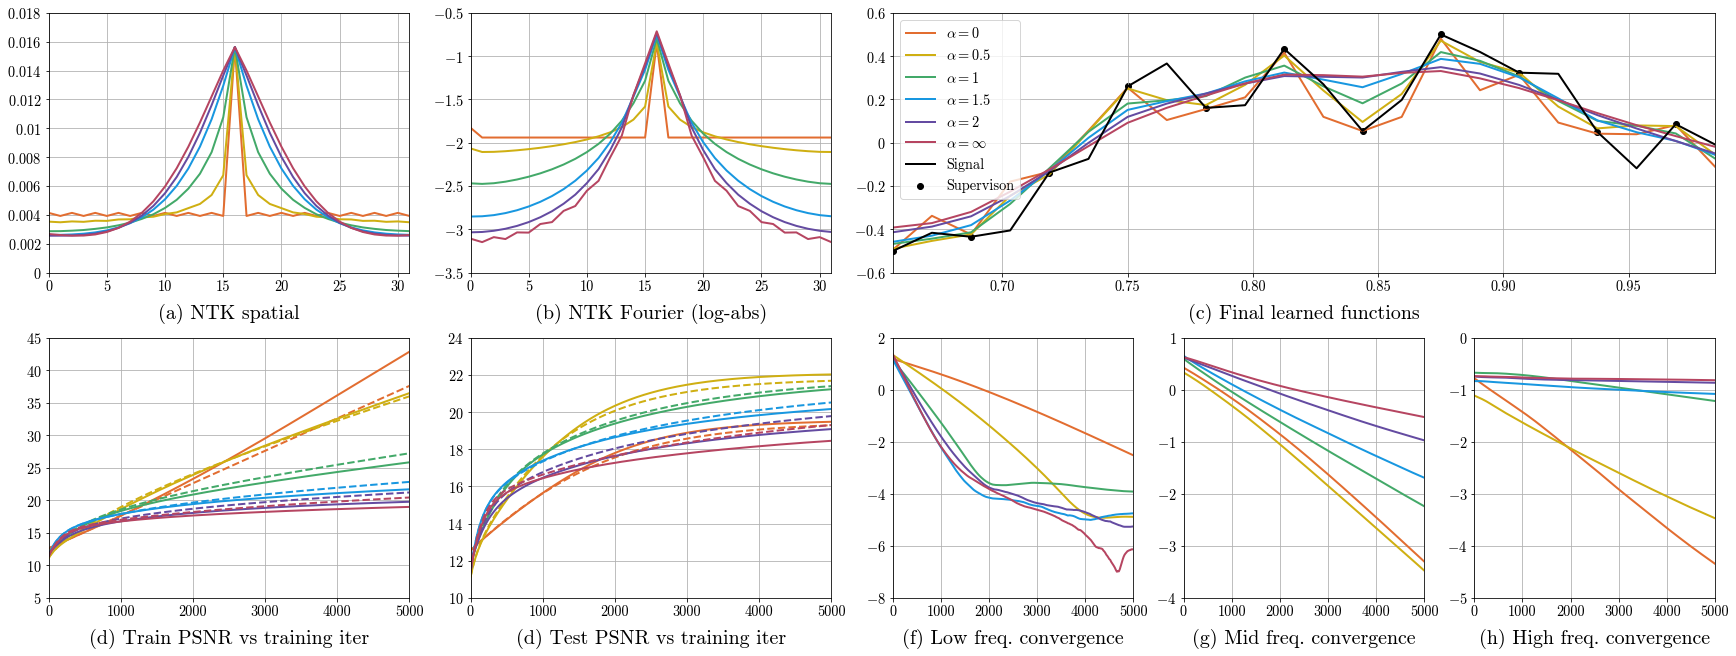

In [38]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize': 20,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if 'opt' not in n]

N_kernels = len(names)

### What's a good colormap ??
# colors_k = [plt.cm.plasma(.8 * (1. - j / (N_kernels-1))) for j in range(N_kernels)]
# colors_k = [plt.cm.terrain(.8 * (1. - j / (N_kernels-1))) for j in range(N_kernels)]
# colors_k = [np.array(plt.cm.jet(1. * (1. - j / (N_kernels-1))))[:3] * .9 for j in range(N_kernels)]
# colors_k = [np.array(plt.cm.rainbow(1. * (1. - j / (N_kernels-1))))[:3] * 1. for j in range(N_kernels)]

colors_k = np.array([[0.8872, 0.4281, 0.1875],
    [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

init_fn, apply_fn, kernel_fn = make_network(*network_size)
run_model = jit(lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab))))

fig3 = plt.figure(constrained_layout=True, figsize=(24,9))
gs = fig3.add_gridspec(6, 12)

### Plot NTK stuff

H_rows = {k : compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names}

ax = fig3.add_subplot(gs[0:3, 0:3])
for c, k in zip(colors_k, H_rows):
  ax.plot(np.fft.fftshift(H_rows[k]), label=k, color=c, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title('(a) NTK spatial', y=title_offset)
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')

ax = fig3.add_subplot(gs[0:3, 3:6])
for c, k in zip(colors_k, H_rows):
  plt.plot(fplot(H_rows[k]), label=k, color=c, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title('(b) NTK Fourier (log-abs)', y=title_offset)
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')

### Plot learned fns

i0, i1 = 42, 64   ### These numbers are arbitrary, just taking a slice
ax = fig3.add_subplot(gs[0:3, 6:12])
for c, k in zip(colors_k, names):
  params = outputs[k][0]
  ax.plot(x_test[i0:i1], run_model(params, ab_dict[k], x_test)[i0:i1], label=k, color=c, linewidth=linewidth)
plt.plot(x_test[i0:i1], s[i0:i1], label='Signal', color='k', linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.scatter(x_train[i0//2:i1//2], s[i0:i1:2], color='k', label='Supervison')
# ax.legend()
ax.set_title('(c) Final learned functions', y=title_offset)
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
ax.legend(loc='upper left')
plt.grid('on')

### Plot loss curves

xvals = xs # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[3:6, 0:3])
for c, k in zip(colors_k, names):
  ax.plot(xvals, outputs[k][1], color=c, label=k, linewidth=linewidth)
  ax.plot(xvals, outputs[k][4][:,1], '--', color=c, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title('(d) Train PSNR vs training iter', y=title_offset)
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')

ax = fig3.add_subplot(gs[3:6, 3:6])
for c, k in zip(colors_k, names):
  ax.plot(xvals, outputs[k][2], color=c, label=k, linewidth=linewidth)
  ax.plot(xvals, outputs[k][4][:,0], '--', color=c, linewidth=linewidth)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title('(d) Test PSNR vs training iter', y=title_offset)
ytick = ax.get_yticks()
ax.set_yticks(ytick)
ax.set_yticklabels([fr'${t:g}$' for t in ytick])
plt.grid('on')


### Plot freq components
letters = ['f','g','h']
prefix = ['Low', 'Mid', 'High']
for i, j in enumerate([1, 4, 15]):
  err_lines = {k : np.log(np.abs(np.fft.fft(np.array(outputs[k][3]))[:,j])) for k in names}
  ax = fig3.add_subplot(gs[3:6, 6+2*i:6+2*i+2])
  for c, k in zip(colors_k, err_lines):
    ax.plot(xs, err_lines[k], label=k, color=c, linewidth=linewidth)
  plt.autoscale(enable=True, axis='x', tight=True)
  ax.set_title(f'({letters[i]}) {prefix[i]} freq. convergence', y=title_offset)
  ytick = ax.get_yticks()
  ax.set_yticks(ytick)
  ax.set_yticklabels([fr'${t:g}$' for t in ytick])
  plt.grid('on')

plt.savefig('posenc_fig2.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

